In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import glob
import collections
import random
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFilter

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [ ]:
from matplotlib import pyplot

In [ ]:
os.chdir('gdrive/My Drive/hotdog_data')

In [ ]:
seed = 42
random.seed(seed)

In [ ]:
def load_image(imgname):
    image = Image.open(imgname).convert('RGB')
    if image.size[0] < image.size[1]:
        image = image.rotate(90, expand=True)
    image = image.resize((224,224))
    return image

In [9]:
image_list = []
for filename in tqdm(glob.glob('train/hotdog/*.jpg')):
    im = load_image(filename)
    image_list.append((im,1))

100%|██████████| 708/708 [00:05<00:00, 138.00it/s]


In [10]:
for filename in tqdm(glob.glob('train/not_hotdog/*.jpg')):
    im = load_image(filename)
    image_list.append((im, 0))

100%|██████████| 963/963 [00:07<00:00, 136.15it/s]


# Аугментация

Первое, что мы можем сделать - это расширить тренировочную выборку с помощью аугментации. Используем самые простые техники, вроде вращения / отражения по осям / добавления шума.

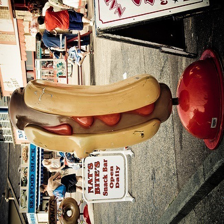

In [11]:
image = image_list[71][0]
image

In [ ]:
hoz_flip = image.transpose(Image.FLIP_LEFT_RIGHT)
ver_flip = image.transpose(Image.FLIP_TOP_BOTTOM)
rotate45 = image.rotate(45)
rotate90 = image.rotate(90)
rotate135 = image.rotate(135)
rotate180 = image.rotate(180)
gaussian5 = image.filter(ImageFilter.GaussianBlur(5))
gaussian3 = image.filter(ImageFilter.GaussianBlur(3))
gaussian1 = image.filter(ImageFilter.GaussianBlur(1))
unsharp = image.filter(ImageFilter.UnsharpMask())

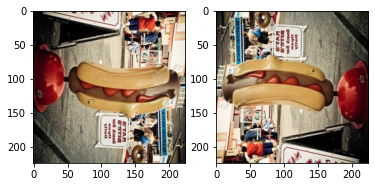

In [13]:
pyplot.subplot(121)
pyplot.imshow(hoz_flip)
pyplot.subplot(122)
pyplot.imshow(ver_flip)

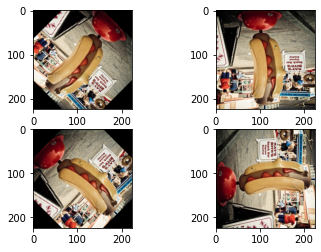

In [14]:
pyplot.subplot(221)
pyplot.imshow(rotate45)
pyplot.subplot(222)
pyplot.imshow(rotate90)
pyplot.subplot(223)
pyplot.imshow(rotate135)
pyplot.subplot(224)
pyplot.imshow(rotate180)

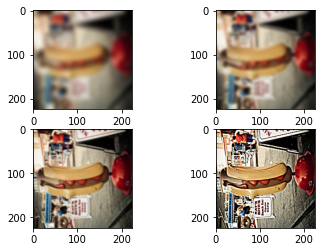

In [15]:
pyplot.subplot(221)
pyplot.imshow(gaussian5)
pyplot.subplot(222)
pyplot.imshow(gaussian3)
pyplot.subplot(223)
pyplot.imshow(gaussian1)
pyplot.subplot(224)
pyplot.imshow(unsharp)

In [ ]:
def augment(image, index):
    augmentations = []
    augmentations.append(image)
    augmentations.append(image.transpose(Image.FLIP_LEFT_RIGHT))
    augmentations.append(image.transpose(Image.FLIP_TOP_BOTTOM))
    augmentations.append(image.rotate(45))
    augmentations.append(image.rotate(90))
    augmentations.append(image.rotate(135))
    augmentations.append(image.rotate(180))
    augmentations.append(image.filter(ImageFilter.GaussianBlur(5)))
    augmentations.append(image.filter(ImageFilter.GaussianBlur(3)))
    augmentations.append(image.filter(ImageFilter.GaussianBlur(1)))
    augmentations.append(image.filter(ImageFilter.UnsharpMask()))
    augmentations = [(image, index) for image in augmentations]
    return augmentations

In [ ]:
images_augmented = []

In [18]:
for image, index in tqdm(image_list):
    images_augmented += augment(image, index)

100%|██████████| 1671/1671 [00:17<00:00, 94.40it/s]


In [ ]:
random.shuffle(images_augmented) #  because we will not train_test_split, which automatically shuffles data

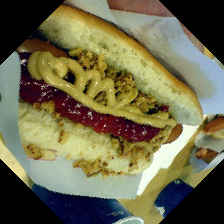

In [20]:
images_augmented[0][0]

# VGG репрезентация

Для ещё одной техники улучшения результата нам стоит получить предсказания на неразмеченной выборке.

In [ ]:
def preprocess_image(image, model):
    image = np.array(image).reshape(1, 224, 224, 3)
    image = preprocess_input(image)
    return model.predict(image).flatten()

In [ ]:
def preprocess_pairs(pairs, model, mode='train'):
    images = [pair[0] for pair in pairs]
    vectors = []
    labels = [pair[1] for pair in pairs]
    for image in tqdm(images):
        vectors.append(preprocess_image(image, model))
    if mode == 'train':  # чтобы не писать отдельную функцию для имён файлов
        labels = np.array(labels)
    return np.array(vectors), labels

In [ ]:
modelvgg = VGG16(weights='imagenet')
modelvgg.layers.pop()
modelvgg = Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-2].output)

In [24]:
X_train, y_train = preprocess_pairs(images_augmented, modelvgg)

100%|██████████| 18381/18381 [08:40<00:00, 35.33it/s]


In [ ]:
X_train_split, X_dev, y_train_split, y_dev = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)

In [ ]:
linear_classifier = LinearSVC(random_state=seed, tol=1e-5)

In [27]:
linear_classifier.fit(X_train_split, y_train_split)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=1e-05,
          verbose=0)

In [28]:
linear_classifier.score(X_dev, y_dev)

0.9804241435562806

Аугментация увеличила точность ещё на 0.7%. Неплохо, учитывая, что точность предсказаний у нас уже была 97.3%! (и это мы ещё протестили на 10% данных, которые в обучении не участвовали, так что со всей выборкой результаты должны быть ещё лучше).

Оговорка: конечно, для полноценного сравнения стоило бы сначала отделить тестовую выборку random split'ом, как было в 3 части, и отдельно аугментировать "тренировочную", но эффект аугментации и так очевиден. Загрузим неразмеченную выборку.

In [29]:
test_images = []
for filename in tqdm(glob.glob('test/*.jpg')):
    im = load_image(filename)
    test_images.append((im,filename))

100%|██████████| 325/325 [00:02<00:00, 152.35it/s]


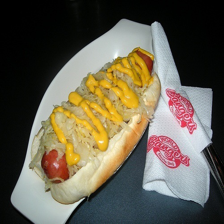

In [30]:
test_images[0][0]

In [31]:
X_test, filenames = preprocess_pairs(test_images, modelvgg)  # на будущее

100%|██████████| 325/325 [00:09<00:00, 35.71it/s]


# Pseudo-labeling

Для улучшения результатов непосредственно на выборке используем pseudo-labeling. Для этого аугментируем неразмеченную выборку, после чего будем по частям её предсказывать, объединять уже существующие векторы и предсказания с новыми, и переобучать заново, и так пока выборка не закончится. На итоговых данных обучим выборку в последний раз.

In [32]:
test_images_augmented = []
for image, filename in tqdm(test_images):
    test_images_augmented += augment(image, filename)

100%|██████████| 325/325 [00:03<00:00, 95.41it/s] 


In [ ]:
random.shuffle(test_images_augmented)

In [34]:
X_test_augmented, _ = preprocess_pairs(test_images_augmented, modelvgg, 'test')

100%|██████████| 3575/3575 [01:41<00:00, 35.32it/s]


In [ ]:
def batches(data, n):
    for i in range(0, len(data), n):
        yield data[i:i + n]

In [ ]:
X_test_chunked = list(batches(X_test_augmented, 100))

In [37]:
for _ in tqdm(range(len(X_test_chunked))):
    batch = X_test_chunked.pop()
    linear_classifier = LinearSVC(random_state=seed, tol=1e-5, max_iter=5000)
    linear_classifier.fit(X_train, y_train)
    batch_predict = linear_classifier.predict(batch)
    X_train = np.vstack((X_train, batch))
    y_train = np.hstack((y_train, batch_predict))

100%|██████████| 36/36 [05:52<00:00,  9.78s/it]


Натренируем последний классификатор и получим окончательные результаты!

In [38]:
linear_classifier = LinearSVC(random_state=seed, tol=1e-5, max_iter=5000)
linear_classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=42, tol=1e-05,
          verbose=0)

In [ ]:
predictions = list(linear_classifier.predict(X_test))

In [ ]:
out_items = list(zip(filenames, predictions))

In [ ]:
output = [f'{pair[0][5:]} {pair[1]}' for pair in out_items]
output.sort()

In [ ]:
with open('test_labels.txt', 'w') as out_file:
    out_file.write('\n'.join(output))
out_file.close()